In [11]:
import os
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn import tree
import numpy as np
import pandas as pd
import random
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [12]:
max_T = 100
thresh = 1e-4 # Hyper-
#set random seed to make results reproducible
seed = 1234
np.random.seed(seed)
random.seed(seed)

# Read Dataset

In [13]:
path = "../predict-responsibly/data/"
dataset = "adult"
protected_feature = "sex"
K = 1
db = np.load(os.path.join(path,dataset,"{}{}_{}.npz".format(dataset,K,protected_feature)))

## partition X according to f0

In [14]:
x_val = db["x_train"]
y_val = db["y_train"]
x_test = db["x_test"]
y_test = db["y_test"]

In [15]:
# def res(p, y):
#     # 有noise 吧？？？？？我用这个就拟合不了了
#     return y * ((p>=0.1)/(p + 1e-20) + (p<0.1) * (20 - 100  * p)) +\
# (1-y) * ((p < 0.9)/(1 - p + 1e-20) + (p>=0.9) * (100 * p - 80))

In [16]:
# logits = net.output[:,1] - net.output[:,0]
# in our case, we get the logits directly
logits = np.log(db["ydm_train"]/(1-db["ydm_train"]))
test_logits = np.log(db["ydm_test"]/(1-db["ydm_test"]))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [17]:
best_epoch, best_acc = -1,0
# get the validation index
best_eod = 1
valid_index = np.arange(len(x_val))
#use budget % of the validation set for training
valid_index =random.sample(list(valid_index), int(len(valid_index) * 0.1))


# get the idxs1 and idxs2
idxs1 = random.sample(list(valid_index), int(len(valid_index) * 0.7))
idxs2 = list(set(valid_index) - set(idxs1))

# save the coefficients
h_models = []
losses = []
for t in range(max_T):
    # probs_heldout = sess_run(tf.nn.sigmoid(logits), x_val[idxs2], latent_val[idxs2], sess)
    # logits updates every iteration, thus the probs_heldout is different
    probs_heldout = sigmoid(logits)[idxs2]
    #heldout_loss = np.mean(-y_val[idxs2] * np.log(probs_heldout + 1e-20) - (1-y_val[idxs2]) * np.log(1-probs_heldout + 1e-20))
    heldout_acc =  np.mean((probs_heldout>0.5)==y_val[idxs2])
    # probs = sess_run(tf.nn.sigmoid(logits), x_val, latent_val ,sess)
    # 应为logits是更新的，所以probs也是更新的
    probs = sigmoid(logits)
    val_loss = np.mean(-y_val * np.log(probs + 1e-20) - (1 - y_val) * np.log(1 - probs + 1e-20))
    val_acc = np.mean((probs > 0.5) == y_val)
    EPS = 1e-8
    Y_hat = probs>0.5
    A = db["attr_train"]
    Y = db["y_train"]
    TP = np.multiply(Y, Y_hat)[idxs2]
    mask0 = np.multiply(Y,1-A)[idxs2]
    mask1 = np.multiply(Y,A)[idxs2]
    TP0 = np.multiply(TP, mask0)
    TP1 = np.multiply(TP, mask1)
    tpr0 = np.sum(TP0) / (np.sum(mask0) + EPS)
    tpr1 = np.sum(TP1) / (np.sum(mask1) + EPS)
    losses.append(val_loss)
    heldout_eod = np.abs(tpr0 - tpr1)
    if heldout_eod < best_eod:
        print("Update!")
        best_epoch = t
        best_acc = heldout_acc
        best_eod = heldout_eod
        best_logits_valid = logits
        predicted_test_logits = test_logits
    # delta = res(probs,y_val)
    residual = probs - y_val
    for i in range(3):
        # define the control as the protected feature
        control_idx1 = db["attr_train"][idxs1]
        control_idx2 = db["attr_train"][idxs2]
        if i==0: 
            # X_1, priviledged group
            temp_s = control_idx1
            temp_s_heldout = control_idx2
        elif i ==1:
            # X_0, unpriviledged group
            temp_s = 1- control_idx1
            temp_s_heldout = 1- control_idx2
        else:
            # X
            temp_s = np.ones_like(control_idx1)
            temp_s_heldout = np.ones_like(control_idx2)
        # get the fresh sample for training
        samples1 = np.where(temp_s == 1)[0]
        samples2 = np.where(temp_s_heldout == 1)[0]
        # train the regression model 
        clf = Ridge(alpha=1) # 如果我不变呢
        # clf = DecisionTreeRegressor(max_depth = 5)
        # 如果要把protected feature 去掉 可以考率生成一个新的x_train、valid
        # 我没有去拟合他的 res 那个function，我直接拟合已知的residual （f(x) - y）
        clf.fit(x_val[idxs1][samples1],residual[idxs1][samples1])
        clf_prediction = clf.predict(x_val[idxs2][samples2])
        corr = np.mean(clf_prediction * residual[idxs2][samples2])
        print(t, i, corr)
        if corr > thresh:
            h_models.append(clf)
            # h = (tf.matmul(latent_ph, tf.constant(np.expand_dims(clf.coef_,-1),
            #                                         dtype=tf.float32))[:,0] + clf.intercept_)
            #here, we update h
            h = clf.predict(x_val)
            h_test = clf.predict(x_test)
            # print(h.shape)
            # print(h)
            # when update the logits we only update the logits of current set
            # logits -= .1 * h * s
            control = db["attr_train"]
            #here ydm_test is the f_0(x_test) 
            control_test = db["attr_test"]
            if i == 0:
                # update logits of X_1
                s = control
                s_test = control_test
            elif i == 1:
                # update logits of X_0
                s = 1 - control
                s_test = 1 - control_test
            else:
                # update all logits (This might never used)
                s = np.ones_like(control)
                s_test = np.ones_like(control_test)
            logits -= .1 * h * s
            # update the test logits accordingly
            test_logits -= .1 * h_test * s_test
            break
    # 如果 i == 2 说明没有在X_0,X_1找到合适的h，那么就不更新了
    if i==2:
        break

Update!
0 0 0.012432768896859325
Update!
1 0 0.01203049352312652
2 0 0.011645122532288485
3 0 0.011275824230753215
4 0 0.010921811262291626
5 0 0.01058233825773584
6 0 0.010256699588358282
7 0 0.009944227222260533
8 0 0.009644288682356296
9 0 0.009356285103933097
10 0 0.009079649389301964
11 0 0.00881384445667694
12 0 0.008558361580150635
13 0 0.008312718817434688
14 0 0.008076459521902595
15 0 0.007849150935395937
16 0 0.007630382858224683
17 0 0.007419766392799263
18 0 0.0072169327573696875
19 0 0.007021532166409312
20 0 0.0068332327742621855
21 0 0.006651719678769329
22 0 0.0064766939816969
23 0 0.006307871902904816
24 0 0.006144983945315396
25 0 0.0059877741078660585
26 0 0.005835999143755618
27 0 0.005689427861419881
28 0 0.005547840465796501
29 0 0.005411027937561816
30 0 0.005278791448141937
31 0 0.005150941808416567
32 0 0.005027298949146517
33 0 0.0049076914312640284
34 0 0.004791955984269032
35 0 0.004679937071073695
36 0 0.0045714864777327315
37 0 0.004466462926587183
38 0 0

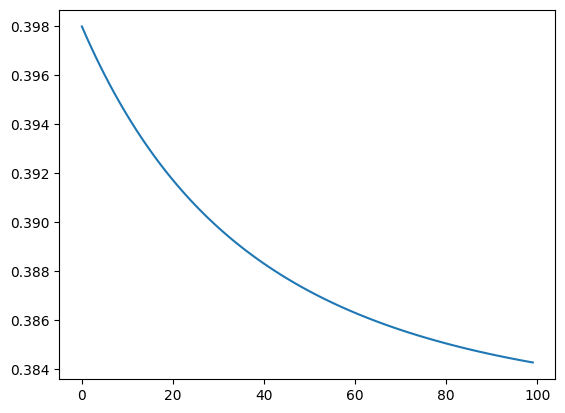

In [21]:
plt.plot(losses)

In [22]:
#检验结果
probs_val = sigmoid(best_logits_valid)
print("Best epoch: {}".format(best_epoch))
print("Best acc for heldout data during training: {}".format(best_acc))
print("Best EOD for heldout data during training: {}".format(best_eod))
print("Valid set whole acc: {}".format(np.mean((probs_val>0.5)==y_val)))
print("Previous acc: {}".format(np.mean((db["ydm_train"]>0.5)==y_val)))
print("Test set acc: {}".format(np.mean((sigmoid(predicted_test_logits)>0.5)==db["y_test"])))
print("Previous acc: {}".format(np.mean((db["ydm_test"]>0.5)==db["y_test"])))

Best epoch: 1
Best acc for heldout data during training: 0.8555555555555555
Best EOD for heldout data during training: 0.06716417922881857
Valid set whole acc: 0.8322013417225718
Previous acc: 0.8347847826992791
Test set acc: 0.8233627728711881
Previous acc: 0.8258623562739543


# Now, do the fairness comparison

In [24]:
#Huangrui add
EPS = 1e-8
Y_hat = sigmoid(predicted_test_logits)>0.5
Y_hat_pre = db["ydm_test"]>0.5
A = db["attr_test"]
Y = db["y_test"]
TP = np.multiply(Y, Y_hat)
TP_pre = np.multiply(Y, Y_hat_pre)
mask0 = np.multiply(Y,1-A)
mask1 = np.multiply(Y,A)
TP0 = np.multiply(TP, mask0)
TP1 = np.multiply(TP, mask1)

TP0_pre = np.multiply(TP_pre, mask0)
TP1_pre = np.multiply(TP_pre, mask1)
tpr0 = np.sum(TP0) / (np.sum(mask0) + EPS)
tpr1 = np.sum(TP1) / (np.sum(mask1) + EPS)

tpr0_pre = np.sum(TP0_pre) / (np.sum(mask0) + EPS)
tpr1_pre = np.sum(TP1_pre) / (np.sum(mask1) + EPS)
print(tpr0)
print(tpr1)
#get the error rate of the test set
error_rate = np.mean(Y_hat != Y)
print("Error rate is {}".format(error_rate))
print("Equal opportunity difference is {}".format(abs(tpr0-tpr1)))
print("Previous equal opportunity difference is {}".format(abs(tpr0_pre-tpr1_pre)))

0.5004095004054021
0.2953586497765671
Error rate is 0.17663722712881186
Equal opportunity difference is 0.205050850628835
Previous equal opportunity difference is 0.19239262278126779
